## Installations

In [1]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-11-07 15:55:01


In [ ]:
! pip install skorch
! pip install pytorch-tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## *Imports*

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from pytorch_tabnet.tab_model import TabNetClassifier
from skorch import NeuralNetClassifier
from xgboost import XGBRFClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score,recall_score,accuracy_score,roc_auc_score,precision_score, confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive',)

Mounted at /content/drive


## Loading of Dataset

In [ ]:
fname = f"/content/drive/MyDrive/BT4222/data/feature_eng_combined_v2.csv"
df = pd.read_csv(fname)
#Feature selection for training
df_model = df.copy().drop(columns=['Unnamed: 0', 'id', 'name', 'artists', 'artist_ids', 'release_date_x', 'release_date', 'date', 'lyrics', 'non_stop_lyrics', 'release_month', 'sentiment'])

#Split train and test set
X, y = df_model.drop(columns=['target']), df_model['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Loading of Models

Tuned Naive Bayes Model without SMOTE


In [ ]:
filename = f'/content/drive/MyDrive/BT4222/models/model_gs_nb_tuned.sav'
Tuned_NB_model = pickle.load(open(filename, 'rb'))

Tuned DNN Model with SMOTE

In [ ]:
filename = f'/content/drive/MyDrive/BT4222/models/model_nn_w_tuning.sav'
Tuned_DNN_w_SMOTE_model = pickle.load(open(filename, 'rb'))

TabNet With SMOTE

In [ ]:
Tabnet_clf = TabNetClassifier()
saved_filepath = f'/content/drive/MyDrive/BT4222/models/tabnet_model_SMOTE.zip'
Tabnet_clf.load_model(saved_filepath)

/usr/local/lib/python3.7/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


Ensembled (RFC, GradientBoosted, ExtraTrees) w Oversample (NOT SMOTE) and MinMaxScale

In [ ]:
filename = f'/content/drive/MyDrive/BT4222/models/ensembled_over.sav'
Ensembled_Trees_model = pickle.load(open(filename, 'rb'))

RandomForest (Oversampled) w Scaling

In [ ]:
filename = f'/content/drive/MyDrive/BT4222/models/rfc_over_tuned.sav'
Random_forest_model = pickle.load(open(filename, 'rb'))

XGBoost Smote Scaled

In [ ]:
filename = f'/content/drive/MyDrive/BT4222/models/model_xgboost_tuned_smote_npy_ver.sav'
XGB_SMOTE_Scaled = pickle.load(open(filename, 'rb'))

Tuned SVM Classifier

In [ ]:
filename = f'/content/drive/MyDrive/BT4222/models/model_svc_tuned.sav'
Tuned_SVC = pickle.load(open(filename, 'rb'))

### Get altered_train_test set for stacking model

In [ ]:
estimators = [
    ('NB',Tuned_NB_model),
    ('DNN',Tuned_DNN_w_SMOTE_model),
    ('TBNT',Tabnet_clf),
    ('Ensb',Ensembled_Trees_model),
    ('RndmF',Random_forest_model),
    ('XGB',XGB_SMOTE_Scaled),
    ('SVC',Tuned_SVC)
]

predicition_train_list = []
for i in range(0,len(estimators)):
  temp_estimator = estimators[i][1]
  y_pred_hard_component = temp_estimator.predict(X_train)
  if i==1:
    y_pred_hard_component = (y_pred_hard_component > 0.5).astype("int32")
    y_pred_hard_component = y_pred_hard_component.reshape(-1)
  predicition_train_list.append(y_pred_hard_component)


predicition_train_list = np.vstack(predicition_train_list).transpose()

1190/1190 [==============================] - 3s 2ms/step


In [ ]:
predicition_test_list = []
for i in range(0,len(estimators)):
  temp_estimator = estimators[i][1]
  y_pred_component = temp_estimator.predict(X_test)
  if i==1:
    y_pred_component = (y_pred_component > 0.5).astype("int32")
    y_pred_component = y_pred_component.reshape(-1)
  predicition_test_list.append(y_pred_component)


predicition_test_list = np.vstack(predicition_test_list).transpose()

587/587 [==============================] - 1s 2ms/step


In [ ]:
predicition_train_list

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 1]])

## Logistic regression Stacking Model

In [ ]:
basic_lr_model = LogisticRegression()
basic_lr_model.fit(predicition_train_list,y_train)

LogisticRegression()

In [ ]:
y_pred_final = basic_lr_model.predict(predicition_test_list)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     15981
           1       0.72      0.68      0.70      2775

    accuracy                           0.91     18756
   macro avg       0.83      0.82      0.82     18756
weighted avg       0.91      0.91      0.91     18756

Accuracy: 0.9136809554275965
Precision: 0.7228218966846569
Recall: 0.6756756756756757
F1-score: 0.6984540882845968


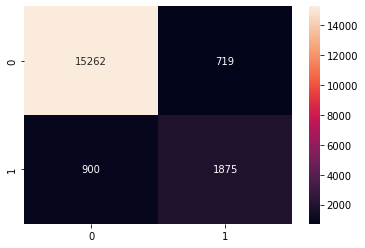

In [ ]:
print(classification_report(y_test,y_pred_final))
print(f"Accuracy: {accuracy_score(y_test,y_pred_final)}")
print(f"Precision: {precision_score(y_test,y_pred_final)}")
print(f"Recall: {recall_score(y_test,y_pred_final)}")
print(f"F1-score: {f1_score(y_test,y_pred_final)}")


cf_matrix = confusion_matrix(y_test,y_pred_final)  
sb.heatmap(cf_matrix, annot=True, fmt='g')

## XGB Stacking Model

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
X_train_temp, X_val_smote, y_train_temp, y_val_smote = train_test_split(predicition_train_list, y_train, test_size=0.33, random_state=42)

In [ ]:
model = XGBRFClassifier()
model.fit(predicition_train_list, y_train)

XGBRFClassifier()

In [ ]:
y_pred_final = model.predict(predicition_test_list)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95     15981
           1       0.72      0.69      0.70      2775

    accuracy                           0.91     18756
   macro avg       0.83      0.82      0.83     18756
weighted avg       0.91      0.91      0.91     18756

Accuracy: 0.9141074856046065
Precision: 0.7186326070623591
Recall: 0.6893693693693693
F1-score: 0.7036968916681994


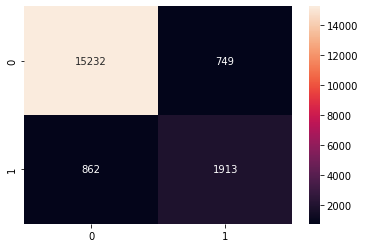

In [ ]:
print(classification_report(y_test,y_pred_final))
print(f"Accuracy: {accuracy_score(y_test,y_pred_final)}")
print(f"Precision: {precision_score(y_test,y_pred_final)}")
print(f"Recall: {recall_score(y_test,y_pred_final)}")
print(f"F1-score: {f1_score(y_test,y_pred_final)}")


cf_matrix = confusion_matrix(y_test,y_pred_final)  
sb.heatmap(cf_matrix, annot=True, fmt='g')

## Random Forest

In [ ]:
rndm_frst_model = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True, bootstrap=True)
rndm_frst_model.fit(predicition_train_list, y_train)

RandomForestClassifier(oob_score=True, random_state=42)

In [ ]:
y_pred_final = rndm_frst_model.predict(predicition_test_list)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     15981
           1       0.73      0.67      0.70      2775

    accuracy                           0.91     18756
   macro avg       0.84      0.81      0.82     18756
weighted avg       0.91      0.91      0.91     18756

Accuracy: 0.9140541693324803
Precision: 0.7292077256602286
Recall: 0.6666666666666666
F1-score: 0.6965361445783133


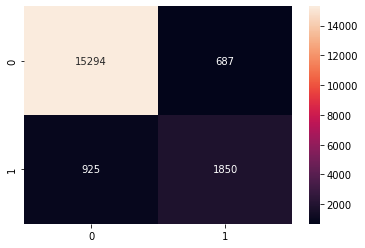

In [ ]:
print(classification_report(y_test,y_pred_final))
print(f"Accuracy: {accuracy_score(y_test,y_pred_final)}")
print(f"Precision: {precision_score(y_test,y_pred_final)}")
print(f"Recall: {recall_score(y_test,y_pred_final)}")
print(f"F1-score: {f1_score(y_test,y_pred_final)}")


cf_matrix = confusion_matrix(y_test,y_pred_final)  
sb.heatmap(cf_matrix, annot=True, fmt='g')